# Image classifcation using Fruitnet dataset
View the dataset [here](https://www.kaggle.com/datasets/shashwatwork/fruitnet-indian-fruits-dataset-with-quality/data)

## 1. Import modules

In [1]:
import csv
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models
from tqdm import tqdm
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score

In [2]:
# Check GPU compatibility
if torch.cuda.is_available():
    print("GPU is available")
    print("GPU device:", torch.cuda.get_device_name(0))
    print("GPU memory:", round(torch.cuda.get_device_properties(0).total_memory/1024**3),"GB")
else:
    print("GPU is not available. Using CPU")
    
CUDA = torch.cuda.is_available()
device = "cuda" if CUDA else "cpu"


GPU is available
GPU device: Tesla P100-PCIE-16GB
GPU memory: 16 GB


## 2. Load data

In [3]:
fruits = ["Apple","Banana","Guava","Lime","Orange","Pomegranate"]
qualities = ["Bad","Good","Mixed"]

fruits_cnt, qualities_cnt = len(fruits), len(qualities)
print(f"Total fruits: {fruits_cnt}. Total qualities: {qualities_cnt}")

input_dir = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"

images = [[[] for j in range(fruits_cnt)] for i in range(qualities_cnt)]

# some edge cases need to be handled due to inconsistent naming
def quality_folder(quality):
    if quality == "Mixed": return f"Mixed Qualit_Fruits"
    return f"{quality} Quality_Fruits"

def fruit_folder(quality,fruit):
    if quality == "Mixed": 
        if fruit == "Lime": return "Lemon"
        return fruit
    
    return f"{fruit}_{quality}"

# load data from folders
for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        dir = f"{input_dir}/{quality_folder(quality)}/{fruit_folder(quality,fruit)}"
        for img_path in glob(f"{dir}/*"):
            img = Image.open(img_path)
            if img.mode == 'RGB': images[quality_id][fruit_id].append(img)
        


Total fruits: 6. Total qualities: 3


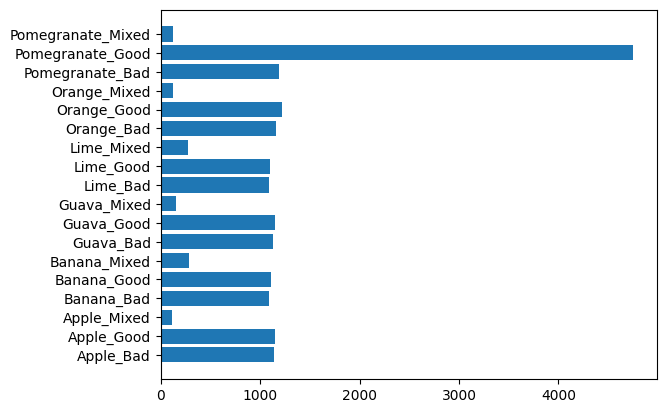

Least number of picture in a category: 113


In [4]:
# summarize data
fruit_label = []
fruit_cnt = []

for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        fruit_label.append(f"{fruit}_{quality}")
        fruit_cnt.append(len(images[quality_id][fruit_id]))

plt.barh(fruit_label,fruit_cnt)
plt.show()

min_pics = 10000
for i in fruit_cnt:
    min_pics = min(min_pics,i)
print(f"Least number of picture in a category: {min_pics}")

## 3. Cleaning data

Our goal is to ensure each category has the same number of picture. Picking about final_size is reasonable since the least number of picture in a category is 113 and a picture can be rotated into 4.

In [5]:
final_size = 450
# Augmentating data for categories with less data points
for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        if len(images[quality_id][fruit_id])<final_size:
            new_images = []
            for i in images[quality_id][fruit_id]:
                for j in range(4):
                    new_images.append(i.rotate(j*90))
            images[quality_id][fruit_id] = new_images

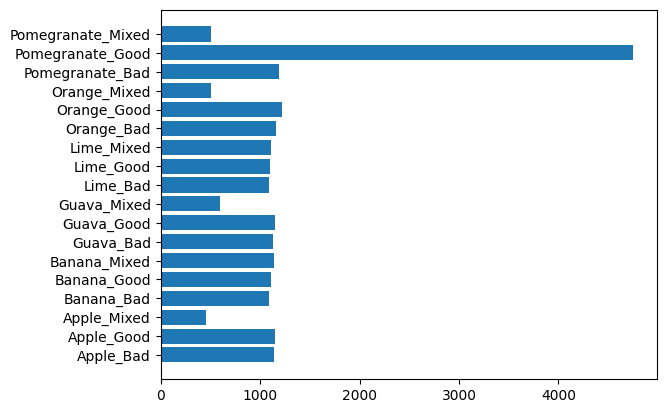

In [6]:
# re-summarize data
fruit_label = []
fruit_cnt = []

for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        fruit_label.append(f"{fruit}_{quality}")
        fruit_cnt.append(len(images[quality_id][fruit_id]))

plt.barh(fruit_label,fruit_cnt)
plt.show()

Now we have to reduce the number of pictures in some category. Due to the nature of our data which is extracted from multiples videos, it makes sense to space out the pictures we pick to ensure data divesity.

In [7]:
for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        size = len(images[quality_id][fruit_id])
        new_images = []
        step = size/final_size
        i = 0
        while int(i) < size and len(new_images) != final_size:
            new_images.append(images[quality_id][fruit_id][int(i)])
            i += step
        assert(len(new_images)==final_size)
        images[quality_id][fruit_id] = new_images
        

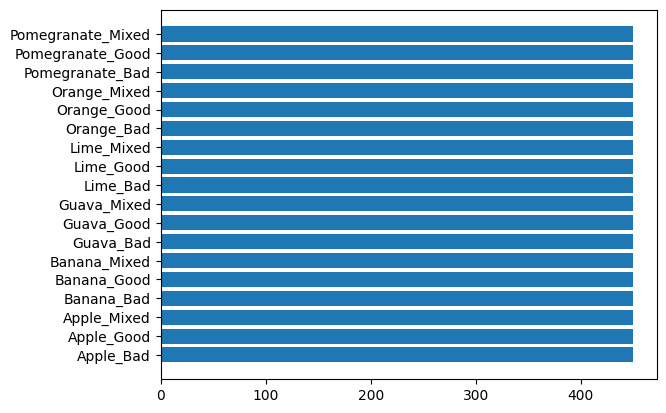

In [8]:
# re-summarize data
fruit_label = []
fruit_cnt = []

for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        fruit_label.append(f"{fruit}_{quality}")
        fruit_cnt.append(len(images[quality_id][fruit_id]))

plt.barh(fruit_label,fruit_cnt)
plt.show()

## 4. Process data

In [9]:
raw_x, raw_y = [], []

# flatten the data
for fruit_id, fruit in enumerate(fruits):
    for quality_id, quality in enumerate(qualities):
        raw_x += images[quality_id][fruit_id]
        raw_y += [ int(quality_id+fruit_id*3) for i in range(len(images[quality_id][fruit_id]))]
assert(len(raw_x)==len(raw_y))

In [10]:
raw_train_x, raw_val_x, raw_train_y, raw_val_y = train_test_split(raw_x,raw_y,test_size=0.25,random_state=42,shuffle=True)

train_x_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
    transforms.Resize((256,256),antialias=True),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(180),
    transforms.CenterCrop((224,224)),
    transforms.Lambda(lambda x: x/255),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.to("cpu"))
])

val_x_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
    transforms.Resize((256,256),antialias=True),
    transforms.CenterCrop((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.to("cpu"))
])

In [11]:
tmp_train_x, tmp_val_x = [], []
for i in raw_train_x: 
    tmp_train_x.append(train_x_transform(i))
for i in raw_val_x:
    tmp_val_x.append(val_x_transform(i))
train_x = torch.stack(tmp_train_x)
val_x = torch.stack(tmp_val_x)

In [12]:
train_y = torch.Tensor(raw_train_y).long()
val_y = torch.Tensor(raw_val_y).long()

In [13]:
# save data
torch.save(train_x, "/tmp/train_x.pt")
torch.save(train_y, "/tmp/train_y.pt")
torch.save(val_x, "/tmp/val_x.pt")
torch.save(val_y, "/tmp/val_y.pt")

## 5. Train model

In [14]:
# load train data
train_x = torch.load("/tmp/train_x.pt",weights_only=True).to(device)
train_y = torch.load("/tmp/train_y.pt",weights_only=True).to(device)
val_x = torch.load("/tmp/val_x.pt",weights_only=True).to(device)
val_y = torch.load("/tmp/val_y.pt",weights_only=True).to(device)

In [15]:
# define data loader
batch_size = 32

class TrainData(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return train_x.shape[0]
    def __getitem__(self,idx):
        return train_x[idx], train_y[idx]

class ValData(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return val_x.shape[0]
    def __getitem__(self,idx):
        return val_x[idx], val_y[idx]

train_data = TrainData()
val_data = ValData()

train_loader = DataLoader(train_data,batch_size=batch_size)
val_loader = DataLoader(val_data,batch_size=batch_size)

In [16]:
model = models.vgg16(weights='DEFAULT')
model.classifier[6] = nn.Linear(in_features=4096,out_features=18)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 231MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00004)

model = model.to(device)
criterion = criterion.to(device)

In [18]:
min_val_loss=10000000
for epoch in range(10):
    print(f"Epochs: {epoch+1}")
    total_loss_train=0
    total_acc_train=0
    print("Training:",end=" ")
    model.train()
    for x, y in tqdm(train_loader):
        output = model(x.float())

        batch_loss = criterion(output, y)
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1)==y).sum().item()
        total_acc_train += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss_val=0
    total_acc_val=0
    
    print("Validating:",end=" ")
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_loader):
            output = model(x.float())
            batch_loss = criterion(output, y)
            total_loss_val += batch_loss.item()
            
            acc = (output.argmax(dim=1)==y).sum().item()
            total_acc_val += acc

    print(
        f'Epochs: {epoch+1} | Train Loss: {total_loss_train / len(train_x):.3f}\
        | Train Accuracy: {total_acc_train/len(train_x):.3f}\
        | Val Loss: {total_loss_val/len(val_x):.3f}\
        | Val Accuracy:{total_acc_val/len(val_x):.3f}'
    )

    if min_val_loss>total_loss_val/len(val_x):
        min_val_loss = total_loss_val/len(val_x)
        torch.save(model.state_dict(), "/kaggle/working/model.pt")
        print(f"Save model because val loss improve loss {min_val_loss:.3f}")
    
    print("-"*50)

Epochs: 1
Training: 

100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.71it/s]


Epochs: 1 | Train Loss: 0.024        | Train Accuracy: 0.760        | Val Loss: 0.007        | Val Accuracy:0.927
Save model because val loss improve loss 0.007
--------------------------------------------------
Epochs: 2
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.69it/s]


Epochs: 2 | Train Loss: 0.005        | Train Accuracy: 0.947        | Val Loss: 0.004        | Val Accuracy:0.961
Save model because val loss improve loss 0.004
--------------------------------------------------
Epochs: 3
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.70it/s]


Epochs: 3 | Train Loss: 0.003        | Train Accuracy: 0.967        | Val Loss: 0.003        | Val Accuracy:0.961
Save model because val loss improve loss 0.003
--------------------------------------------------
Epochs: 4
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.68it/s]


Epochs: 4 | Train Loss: 0.001        | Train Accuracy: 0.986        | Val Loss: 0.003        | Val Accuracy:0.966
Save model because val loss improve loss 0.003
--------------------------------------------------
Epochs: 5
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.70it/s]


Epochs: 5 | Train Loss: 0.001        | Train Accuracy: 0.991        | Val Loss: 0.003        | Val Accuracy:0.968
Save model because val loss improve loss 0.003
--------------------------------------------------
Epochs: 6
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.70it/s]


Epochs: 6 | Train Loss: 0.001        | Train Accuracy: 0.984        | Val Loss: 0.005        | Val Accuracy:0.949
--------------------------------------------------
Epochs: 7
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.70it/s]


Epochs: 7 | Train Loss: 0.001        | Train Accuracy: 0.989        | Val Loss: 0.007        | Val Accuracy:0.937
--------------------------------------------------
Epochs: 8
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.69it/s]


Epochs: 8 | Train Loss: 0.001        | Train Accuracy: 0.992        | Val Loss: 0.002        | Val Accuracy:0.980
Save model because val loss improve loss 0.002
--------------------------------------------------
Epochs: 9
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.69it/s]


Epochs: 9 | Train Loss: 0.000        | Train Accuracy: 0.996        | Val Loss: 0.002        | Val Accuracy:0.981
--------------------------------------------------
Epochs: 10
Training: 

100%|██████████| 190/190 [00:47<00:00,  4.02it/s]


Validating: 

100%|██████████| 64/64 [00:05<00:00, 12.70it/s]

Epochs: 10 | Train Loss: 0.000        | Train Accuracy: 0.999        | Val Loss: 0.002        | Val Accuracy:0.981
--------------------------------------------------


## 5. Evaluate model

In [19]:
# load model best state dict
model.load_state_dict(torch.load("/kaggle/working/model.pt",weights_only=True))
model = model.to(device)

In [20]:
confusion_table = [[0 for i in range(18)]  for i in range(18)]
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in val_loader:
        output = model(x.float()) 
        result = output.argmax(dim=1)
        for i,j in zip(result,y):
            confusion_table[i][j] += 1 
            y_true.append(i.item())
            y_pred.append(j.item())

In [21]:
for i in confusion_table:
    print(i)
f1_scores = f1_score(y_true,y_pred,average=None)

general_f1_score = 0
for i in f1_scores:
    general_f1_score += i
general_f1_score /= 18
print(f"General F1 score: {general_f1_score}")

[117, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0]
[0, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 2, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0, 98, 1, 0, 2, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 112, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 121, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 107, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 107, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 